# Installation

In [1]:
#!pip install ruamel.yaml configargparse spineps hf-deepali TypeSaveArgParse
#!pip install TPTBox --upgrade

# Overview

This tutorial will give you an overview of how to get from a DICOM dump to a processed Dataset with segmentations.

abbreviations:
POI: Point of interest

Steps:

(1) Dicom export to BIDS dataset

(2) Stitching

(3) Segmentation TotalVibeSegmentator and Spineps

(4) Points of Interest (POI) 

(5) Point registration

(6) Deformable Registration for different breath holds compensation

## 1 Dicom export to BIDS dataset

Short overview:

A BIDS dataset is a file naming convention.

The following rules should be known and weakly enforced:

- A dataset folder should start with 'dataset-{YOUR-NAME}'
- The next level folders are:
  - rawdata: for all imaging data.
  - derivative: for all generated data, like segmentation.
A file should look like:

sub-{Subject name}_ses-{Session}_{key}-{value}*_{format}.{filetype}
- Subject name: Unique identifier 
- Session: Session id. Optional if there is only one session
- Any number of key/value pairs. Keys are unique. The defined keys are here: https://bids-specification.readthedocs.io/en/stable/appendices/entities.html . Our tool enforces a certain order. See tutorial_BIDS_files.ipynb
- format: type of acquisition like ct, T2w, VIBE, MPRage
Do not use '_' in any key or values. 

See https://bids-specification.readthedocs.io/en/stable/ for a detailed description of what BIDS is.

In [2]:
from TPTBox.core.bids_files import entities_keys, formats

print("Known formats:\n", "; ".join(formats))
print()
print()
print("Order of keys we enforce:\n", "; ".join(entities_keys.keys()))

Known formats:
 ct; dixon; T2c; T1c; pd; mevibe; vibe; T1w; T2w; T2star; TIRM; STIR; T2haste; flair; DWI; IR; SE; SE-SAT; GRE; PWI; DTI; R2star; radiomics; MPR; IRT; MES; MEGR; MP2RAG; MPM; MT; MT; T1map; T2map; T2starmap; R1map; R2map; R2starmap; PDmap; MTRmap; MTsat; UNIT1; T1rho; MWFmap; MTVmap; Chimap; S0map; M0ma; T1w; T2w; PDw; T2starw; FLAIR; inplaneT1; inplaneT2; PDT2; angio; T2star; FLASH; VF; defacemas; dw; TB1TFL; TB1RFM; RB1CO; TB1AF; TB1DA; TB1EP; TB1SRG; TB1ma; RB1ma; ep; phase1; phase2; magnitude1; magnitude2; magnitude; fieldma; phasedif; sbre; cb; bol; as; m0sca; aslcontex; asllabelin; phas; noR; ee; iee; sti; ME; channel; coordsyste; headshap; electrode; marker; me; sti; PE; bloo; pe; event; physio; sti; TEM; SEM; uCT; BF; DF; PC; DIC; FLUO; CONF; PLI; CARS; 2PE; MPE; SR; NLO; OCT; SPIM; XPC; phot; stat; snp; log; msk; ctd; model; poi; uncertainty; angles; subvar; logit; localizer


Order of keys we enforce:
 sub; ses; sequ; acq; task; chunk; hemi; sample; ce; trc; st

### Extraction

This function extracts a dicom folder and converts it to a BIDS-like Niffty folder.

The names are created like this: DICOM:Key is given Dicom key
      
`dataset-{NAME}/rawdate/sub-{DICOM:PatientID}/ses-{DICOM:StudyDate}/{format}/sub-{DICOM:PatientID}_ses-{DICOM:StudyDate}_sequ-{DICOM:SeriesNumber}_acq-{sag|ax|cor|iso}_{format}.nii.gz`


And a .json, where the DICOM-Keys are saved.

To get {format} we use string matching and the dicom "SeriesDescription" key. As this is a free text, it will not always work. Then we default to "mr," and you have to manually rename them.


You can use make_subject_chunks = n [int] for a very large dataset. Then, we put an additional folder with the first n letters between the raw data and the sub-folder.

In [3]:
from pathlib import Path

from TPTBox.segmentation.TotalVibeSeg.auto_download import _download

## Download the Dicom Example
path_to_dicom_dataset = Path("tutorial_data_processing").absolute()
target_folder = Path(path_to_dicom_dataset).parent

if not path_to_dicom_dataset.exists():
    _download(
        "https://github.com/robert-graf/TotalVibeSegmentator/releases/download/example/tutorial_data_processing.zip",
        path_to_dicom_dataset,
        text="example"
    )

dataset_name = Path(path_to_dicom_dataset).name.replace("_", "-")  # TODO Remove
dataset = target_folder / f"dataset-{dataset_name}"

tutorial_data_processing.zip: 276MB [00:17, 16.8MB/s]                            


Extracting example...


In [4]:
from TPTBox.core.dicom.dicom_extract import extract_dicom_folder

extract_dicom_folder(Path(path_to_dicom_dataset), dataset, use_session=True, n_cpu=10, skip_localizer=True)

## Example for https://data.mendeley.com/datasets/k57fr854j2/2, where they annonomieced the subject, and we have to extract them from the filename/folder structure
# extract_dicom_folder(Path(path_to_dicom_dataset), dataset,use_session=True,n_cpu=10,override_subject_name=lambda x,y: y.name.split("_")[-2],skip_localizer=True)

[*] Start 1.3.46.670589.11.45000.5.0.8396.2023012819261509948_DERIVED,PRIMARY,OP,OP,DERIVED
[*] Start 1.3.46.670589.11.45000.5.0.8396.2023012819261509948_DERIVED,PRIMARY,F,F,DERIVED
[*] Start 1.3.46.670589.11.45000.5.0.8396.2023012819261509948_DERIVED,PRIMARY,IP,IP,DERIVED
[*] Start 1.3.46.670589.11.45000.5.0.8396.2023012819261509948_DERIVED,PRIMARY,W,W,DERIVED
[*] Start 1.3.46.670589.11.45000.5.0.12564.2023012819483068100__1.3.46.670589.11.45000.5.0.12564.2023012819483068101.1
[*] Start 1.3.46.670589.11.45000.5.0.12564.2023012819293551090__1.3.46.670589.11.45000.5.0.12564.2023012819293551091.1
[*] Start 1.3.46.670589.11.45000.5.0.8396.2023012819390122433_DERIVED,PRIMARY,F,F,DERIVED
[*] Start 1.3.46.670589.11.45000.5.0.8396.2023012819390122433_DERIVED,PRIMARY,W,W,DERIVED
[*] Start 1.3.46.670589.11.45000.5.0.8396.2023012819390122433_DERIVED,PRIMARY,IP,IP,DERIVED
[*] Start 1.3.46.670589.11.45000.5.0.11048.2023012819522001045_DERIVED,PRIMARY,W,W,DERIVED
[ ] /DATA/NAS/tools/TPTBox/tutorial

Image orientations not consistent through all slices
---------------------------------------------------------
[6.12323426e-17 1.00000000e+00 0.00000000e+00] [1. 0. 0.]
[ 0.  0. -1.] [ 0.  0. -1.]
---------------------------------------------------------


[*] Save  /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-202_acq-ax_part-outphase_T2w.nii.gz
[*] Start 1.3.46.670589.11.45000.5.0.8396.2023012819434798492_DERIVED,PRIMARY,IP,IP,DERIVED
[ ] /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-402_acq-sag_part-inphase_T2w.json
[*] Save  /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-202_acq-ax_part-inphase_T2w.nii.gz
[*] Start 1.3.46.670589.11.45000.5.0.8396.2023012819161227748_ORIGINAL,PRIMARY,M_FFE,M,FFE
[*] Save  /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-202_acq-ax_part-fat_T2w.nii.gz
[ ] /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-202

At least 3 slices are needed for correct conversion
---------------------------------------------------------


[*] Save  /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/dixon/sub-111168223_ses-20230128_sequ-503_acq-ax_part-ff_dixon.nii.gz
[*] Save  /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/dixon/sub-111168223_ses-20230128_sequ-503_acq-ax_part-t2-star-unspecif-t2-star_dixon.nii.gz
[*] Start 1.3.46.670589.11.45000.5.0.4516.2023012819253203009_DERIVED,PRIMARY,M,M,DERIVED
[ ] /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/mr/sub-111168223_ses-20230128_sequ-302_acq-sag_mr.json
[*] Start 1.3.46.670589.11.45000.5.0.12564.2023012819434801098__1.3.46.670589.11.45000.5.0.12564.2023012819434801099.1
[-] Not exported cause of TOO_FEW_SLICES/LOCALIZER, if you want try to export it anyway, set validate_slicecount = False; If it already on False, than dicom2nifti does not allow the export[ ] /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-

{'1.3.46.670589.11.45000.5.0.12564.2023012819483068100__1.3.46.670589.11.45000.5.0.12564.2023012819483068101.1': None,
 '1.3.46.670589.11.45000.5.0.12564.2023012819293551090__1.3.46.670589.11.45000.5.0.12564.2023012819293551091.1': None,
 '1.3.46.670589.11.45000.5.0.8396.2023012819261509948_DERIVED,PRIMARY,OP,OP,DERIVED': '/DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-202_acq-ax_part-outphase_T2w.nii.gz',
 '1.3.46.670589.11.45000.5.0.8396.2023012819261509948_DERIVED,PRIMARY,IP,IP,DERIVED': '/DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-202_acq-ax_part-inphase_T2w.nii.gz',
 '1.3.46.670589.11.45000.5.0.8396.2023012819261509948_DERIVED,PRIMARY,F,F,DERIVED': '/DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-202_acq-ax_part-f

### Looping over a BIDS dataset
Our tool can automatically scan BIDS folders and create a grouped dictionary where you can pick out the relevant files.

In [5]:
from TPTBox import BIDS_FILE, BIDS_Global_info

bgi = BIDS_Global_info(dataset, ["rawdata", "rawdata_stiched", "derivative"])
stitching_candidate: list[BIDS_FILE] = []
epsilon = 0.2
for name, subj in bgi.iter_subjects():
    print("Subject identifier", name)
    q = subj.new_query()
    # Filter by some rules
    q.flatten()
    q.filter_filetype("nii.gz")
    q.unflatten()
    for fam in q.loop_dict():
        print(f"New Family with {fam.keys()}")
        print(fam)
        print()

Subject identifier 111168223 keys 76,  total subjects = 1    
New Family with dict_keys(['T2w'])
T2w                            : [sub-111168223_ses-20230128_sequ-203_acq-ax_part-water_T2w.['json', 'nii.gz']	 parent = rawdata, sub-111168223_ses-20230128_sequ-203_acq-ax_part-inphase_T2w.['json', 'nii.gz']	 parent = rawdata, sub-111168223_ses-20230128_sequ-203_acq-ax_part-outphase_T2w.['json', 'nii.gz']	 parent = rawdata, sub-111168223_ses-20230128_sequ-203_acq-ax_part-fat_T2w.['json', 'nii.gz']	 parent = rawdata]

New Family with dict_keys(['T2w'])
T2w                            : [sub-111168223_ses-20230128_sequ-402_acq-sag_part-water_T2w.['json', 'nii.gz']	 parent = rawdata, sub-111168223_ses-20230128_sequ-402_acq-sag_part-inphase_T2w.['json', 'nii.gz']	 parent = rawdata, sub-111168223_ses-20230128_sequ-402_acq-sag_part-fat_T2w.['json', 'nii.gz']	 parent = rawdata]

New Family with dict_keys(['T2w'])
T2w                            : [sub-111168223_ses-20230128_sequ-401_acq-sag_part-in

You should observe that we already grouped files into "familes" based on there BIDS-keys.

If you just want to find all familes that have a sagittal inphase T2w image you can filter by the BIDS keys.

If you produce a segmentation, the BIDS-Keys should in a way that the land in the same family as the source file. If you want to see this effect you can rerun this cell after we crated our segmentation.

If you do not care about families you can flatten the looping.



In [6]:
from TPTBox import BIDS_FILE, BIDS_Global_info

bgi = BIDS_Global_info(dataset, ["rawdata", "rawdata_stiched", "derivative"])
stitching_candidate: list[BIDS_FILE] = []
epsilon = 0.2
for name, subj in bgi.iter_subjects():
    print("Subject identifier", name)
    q = subj.new_query()
    # Filter by some rules
    q.flatten()
    q.filter_filetype("nii.gz")
    q.filter_format("T2w")
    q.filter("acq", "sag")
    q.filter("part", "inphase")
    for fam in q.loop_list():
        print(fam)
        print()

Subject identifier 111168223 keys 76,  total subjects = 1    
sub-111168223_ses-20230128_sequ-402_acq-sag_part-inphase_T2w.['json', 'nii.gz']	 parent = rawdata

sub-111168223_ses-20230128_sequ-401_acq-sag_part-inphase_T2w.['json', 'nii.gz']	 parent = rawdata

sub-111168223_ses-20230128_sequ-403_acq-sag_part-inphase_T2w.['json', 'nii.gz']	 parent = rawdata



The following example automatically makes lists for the upcoming stitching example, assuming that the same spacing and bids_format mean we can merge them. You need not read the loop in detail to understand this tutorial.

In [7]:
from math import floor

from TPTBox import BIDS_FILE, BIDS_Global_info
from TPTBox.core.bids_constants import sequence_splitting_keys

print("if one of the values of these keys is diffrent, than it is considered a other sequence:", sequence_splitting_keys)
print("sub will alway split")

print("Lets search for candidate for merging. For this we have to remove the sequ-key from sequence_splitting_keys")
my_splitting_keys = sequence_splitting_keys.copy()
my_splitting_keys.remove("sequ")
my_splitting_keys.append("part")

bgi = BIDS_Global_info(dataset, ["rawdata", "derivative"], sequence_splitting_keys=my_splitting_keys)
stitching_candidate: list[BIDS_FILE] = []
epsilon = 0.2
for name, subj in bgi.iter_subjects():
    print("Subject identifier", name)
    q = subj.new_query()
    # Filter by some rules
    q.flatten()
    q.filter_filetype("nii.gz")
    q.unflatten()
    for fam in q.loop_dict():
        print(fam)
        for key, file_list in fam.items():
            if key == "mr":
                continue
            if len(file_list) == 1:
                continue
            # This code is only an example, where we group images with the same orientation and zoom, so we know what are potential stitching targets.
            # We use _format key as the initial split, so T1w and T2w will not be stiched
            matching_group = []
            for files in range(len(file_list)):
                f1 = file_list[files]
                if f1 is None:
                    continue
                # # We assume the files do not want to get stitched if you have a different one-hundred digits.
                idx1 = int(f1.get("sequ", "0")) if f1.get("sequ", "0").isdigit() else 0  # type: ignore
                grid1 = f1.get_grid_info()
                if grid1 is None:
                    continue
                current_group = [f1]  # Start a new group with the current file
                for j in range(files + 1, len(file_list)):
                    f2 = file_list[j]
                    if f2 is None:
                        continue
                    grid2 = f2.get_grid_info()
                    if grid2 is None:
                        continue
                    idx2 = int(f2.get("sequ", "0")) if f1.get("sequ", "0").isdigit() else 0  # type: ignore
                    if floor(idx1 / 100) != (floor(idx2 / 100)):
                        continue
                    # Check if orientation matches
                    if grid1.orientation == grid2.orientation:
                        # Check if zoom is within the tolerance
                        zoom_diff = [abs(z1 - z2) for z1, z2 in zip(grid1.zoom, grid2.zoom)]
                        if all(diff <= epsilon for diff in zoom_diff):
                            current_group.append(f2)
                            file_list[j] = None  # type: ignore
                # Add the group if it has more than one file
                if len(current_group) > 1:
                    stitching_candidate.append(current_group)
for files in stitching_candidate:
    print(files)

if one of the values of these keys is diffrent, than it is considered a other sequence: ['ses', 'sequ', 'acq', 'hemi', 'sample', 'ce', 'trc', 'stain', 'res', 'dir', 'run', 'split', 'chunk']
sub will alway split
Lets search for candidate for merging. For this we have to remove the sequ-key from sequence_splitting_keys
Subject identifier 111168223 keys 76,  total subjects = 1    
T2w                            : [sub-111168223_ses-20230128_sequ-203_acq-ax_part-water_T2w.['json', 'nii.gz']	 parent = rawdata, sub-111168223_ses-20230128_sequ-201_acq-ax_part-water_T2w.['json', 'nii.gz']	 parent = rawdata, sub-111168223_ses-20230128_sequ-202_acq-ax_part-water_T2w.['json', 'nii.gz']	 parent = rawdata]
dixon                          : [sub-111168223_ses-20230128_sequ-503_acq-ax_part-water_dixon.['json', 'nii.gz']	 parent = rawdata, sub-111168223_ses-20230128_sequ-501_acq-ax_part-water_dixon.['json', 'nii.gz']	 parent = rawdata, sub-111168223_ses-20230128_sequ-502_acq-ax_part-water_dixon.['json'

### Renaming BIDS data

We can create a new BIDS_FILE, by defining changes to a file.

Example:

/path/to/data/dataset-example/rawdata/sub-0001/ses-12341234/anat/sub-0001_ses-12341234_acq-iso_part-inphase_ct.nii.gz

-->

/path/to/data/dataset-example/derivatives/sub-0001/ses-12341234/anat/sub-0001_ses-12341234_acq-iso_mod-ct_seg-lung_msk.nii.gz


In [8]:
from TPTBox import BIDS_FILE

f = BIDS_FILE(
    "/path/to/data/dataset-example/rawdata/sub-0001/ses-12341234/anat/sub-0001_ses-12341234_acq-iso_part-inphase_ct.nii.gz",
    dataset="/path/to/data/dataset-example/",
)
print(f.file["nii.gz"])
print("-->")
print(
    f.get_changed_path(
        file_type="nii.gz", bids_format="msk", parent="derivatives", info={"part": None, "mod": f.bids_format, "seg": "lung"}
    )
)


/path/to/data/dataset-example/rawdata/sub-0001/ses-12341234/anat/sub-0001_ses-12341234_acq-iso_part-inphase_ct.nii.gz
-->
/path/to/data/dataset-example/derivatives/sub-0001/ses-12341234/anat/sub-0001_ses-12341234_acq-iso_mod-ct_seg-lung_msk.nii.gz


We will validate if you are using defined BIDS keys and throw errors if our validator finds non-standard things. You can turn that off with the 'non_strict_mode' key.

In [9]:
# Test how a error message looks like if you use non_strict_mode=False
non_strict_mode = True
print(
    f.get_changed_path(
        file_type="nii.gz",
        bids_format="COSTUME-BIDS-FORMAT",
        parent="derivatives",
        info={"part": None, "mod": f.bids_format, "seg": "lung"},
        non_strict_mode=non_strict_mode,
    )
)

/path/to/data/dataset-example/derivatives/sub-0001/ses-12341234/anat/sub-0001_ses-12341234_acq-iso_mod-ct_seg-lung_COSTUME-BIDS-FORMAT.nii.gz


# 2 Stitching  
Torax/Fullbody images are often in chunks. We can stich them with the stitching function

In [10]:
from concurrent.futures import ProcessPoolExecutor

from TPTBox import to_nii
from TPTBox.stitching import stitching

derivative_folder = "rawdata_stiched"


def process_files(files: list["BIDS_FILE"]):
    files = sorted(files)  # noqa: PLW2901
    sequ: str = (files[0].get("sequ", "") + "-" if "sequ" in files[0].info else "") + "stiched"  # type: ignore
    out_name = files[0].get_changed_path("nii.gz", info={"sequ": sequ}, parent=derivative_folder, make_parent=True)
    if not out_name.exists():
        stitching(files, out=out_name, is_seg=False, is_ct=files[0].bids_format == "ct", dtype=to_nii(files[0]).dtype, match_histogram=True)
        nii = to_nii(out_name)
        nii.apply_crop_(nii.compute_crop())
        nii.save(out_name)


# Test
process_files(stitching_candidate[0])

# Execute the loop in parallel using a ProcessPoolExecutor
with ProcessPoolExecutor() as executor:
    executor.map(process_files, stitching_candidate)

[*] stitching /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-201-stiched_acq-ax_part-water_T2w.nii.gz
[*] Save /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-201-stiched_acq-ax_part-water_T2w.nii.gz as uint16
[*] stitching /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata_stiched/sub-111168223/ses-20230128/dixon/sub-111168223_ses-20230128_sequ-501-stiched_acq-ax_part-water_dixon.nii.gz[*] stitching /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-401-stiched_acq-sag_part-water_T2w.nii.gz[*] stitching /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/rawdata_stiched/sub-111168223/ses-20230128/dixon/sub-111168223_ses-20230128_sequ-501-stiched_acq-ax_part-t2-star

[ ] resample_from_to: shape=(512, 512, 26),spacing=(0.88, 0.88, 12.0), origin={(216.95, -224.33, 255.84)}, ori=('L', 'A', 'S'), seg=False to shape=(510, 376, 76),spacing=(0.88, 0.88, 12.0), origin={(216.07, -164.65, -344.16)}, ori=('L', 'A', 'S'), seg=False
[ ] resample_from_to: shape=(512, 512, 26),spacing=(0.88, 0.88, 12.0), origin={(216.95, -224.33, -50.16)}, ori=('L', 'A', 'S'), seg=False to shape=(510, 376, 76),spacing=(0.88, 0.88, 12.0), origin={(216.07, -164.65, -344.16)}, ori=('L', 'A', 'S'), seg=False
[ ] resample_from_to: shape=(512, 512, 26),spacing=(0.88, 0.88, 12.0), origin={(216.95, -224.33, -356.16)}, ori=('L', 'A', 'S'), seg=False to shape=(510, 376, 76),spacing=(0.88, 0.88, 12.0), origin={(216.07, -164.65, -344.16)}, ori=('L', 'A', 'S'), seg=False


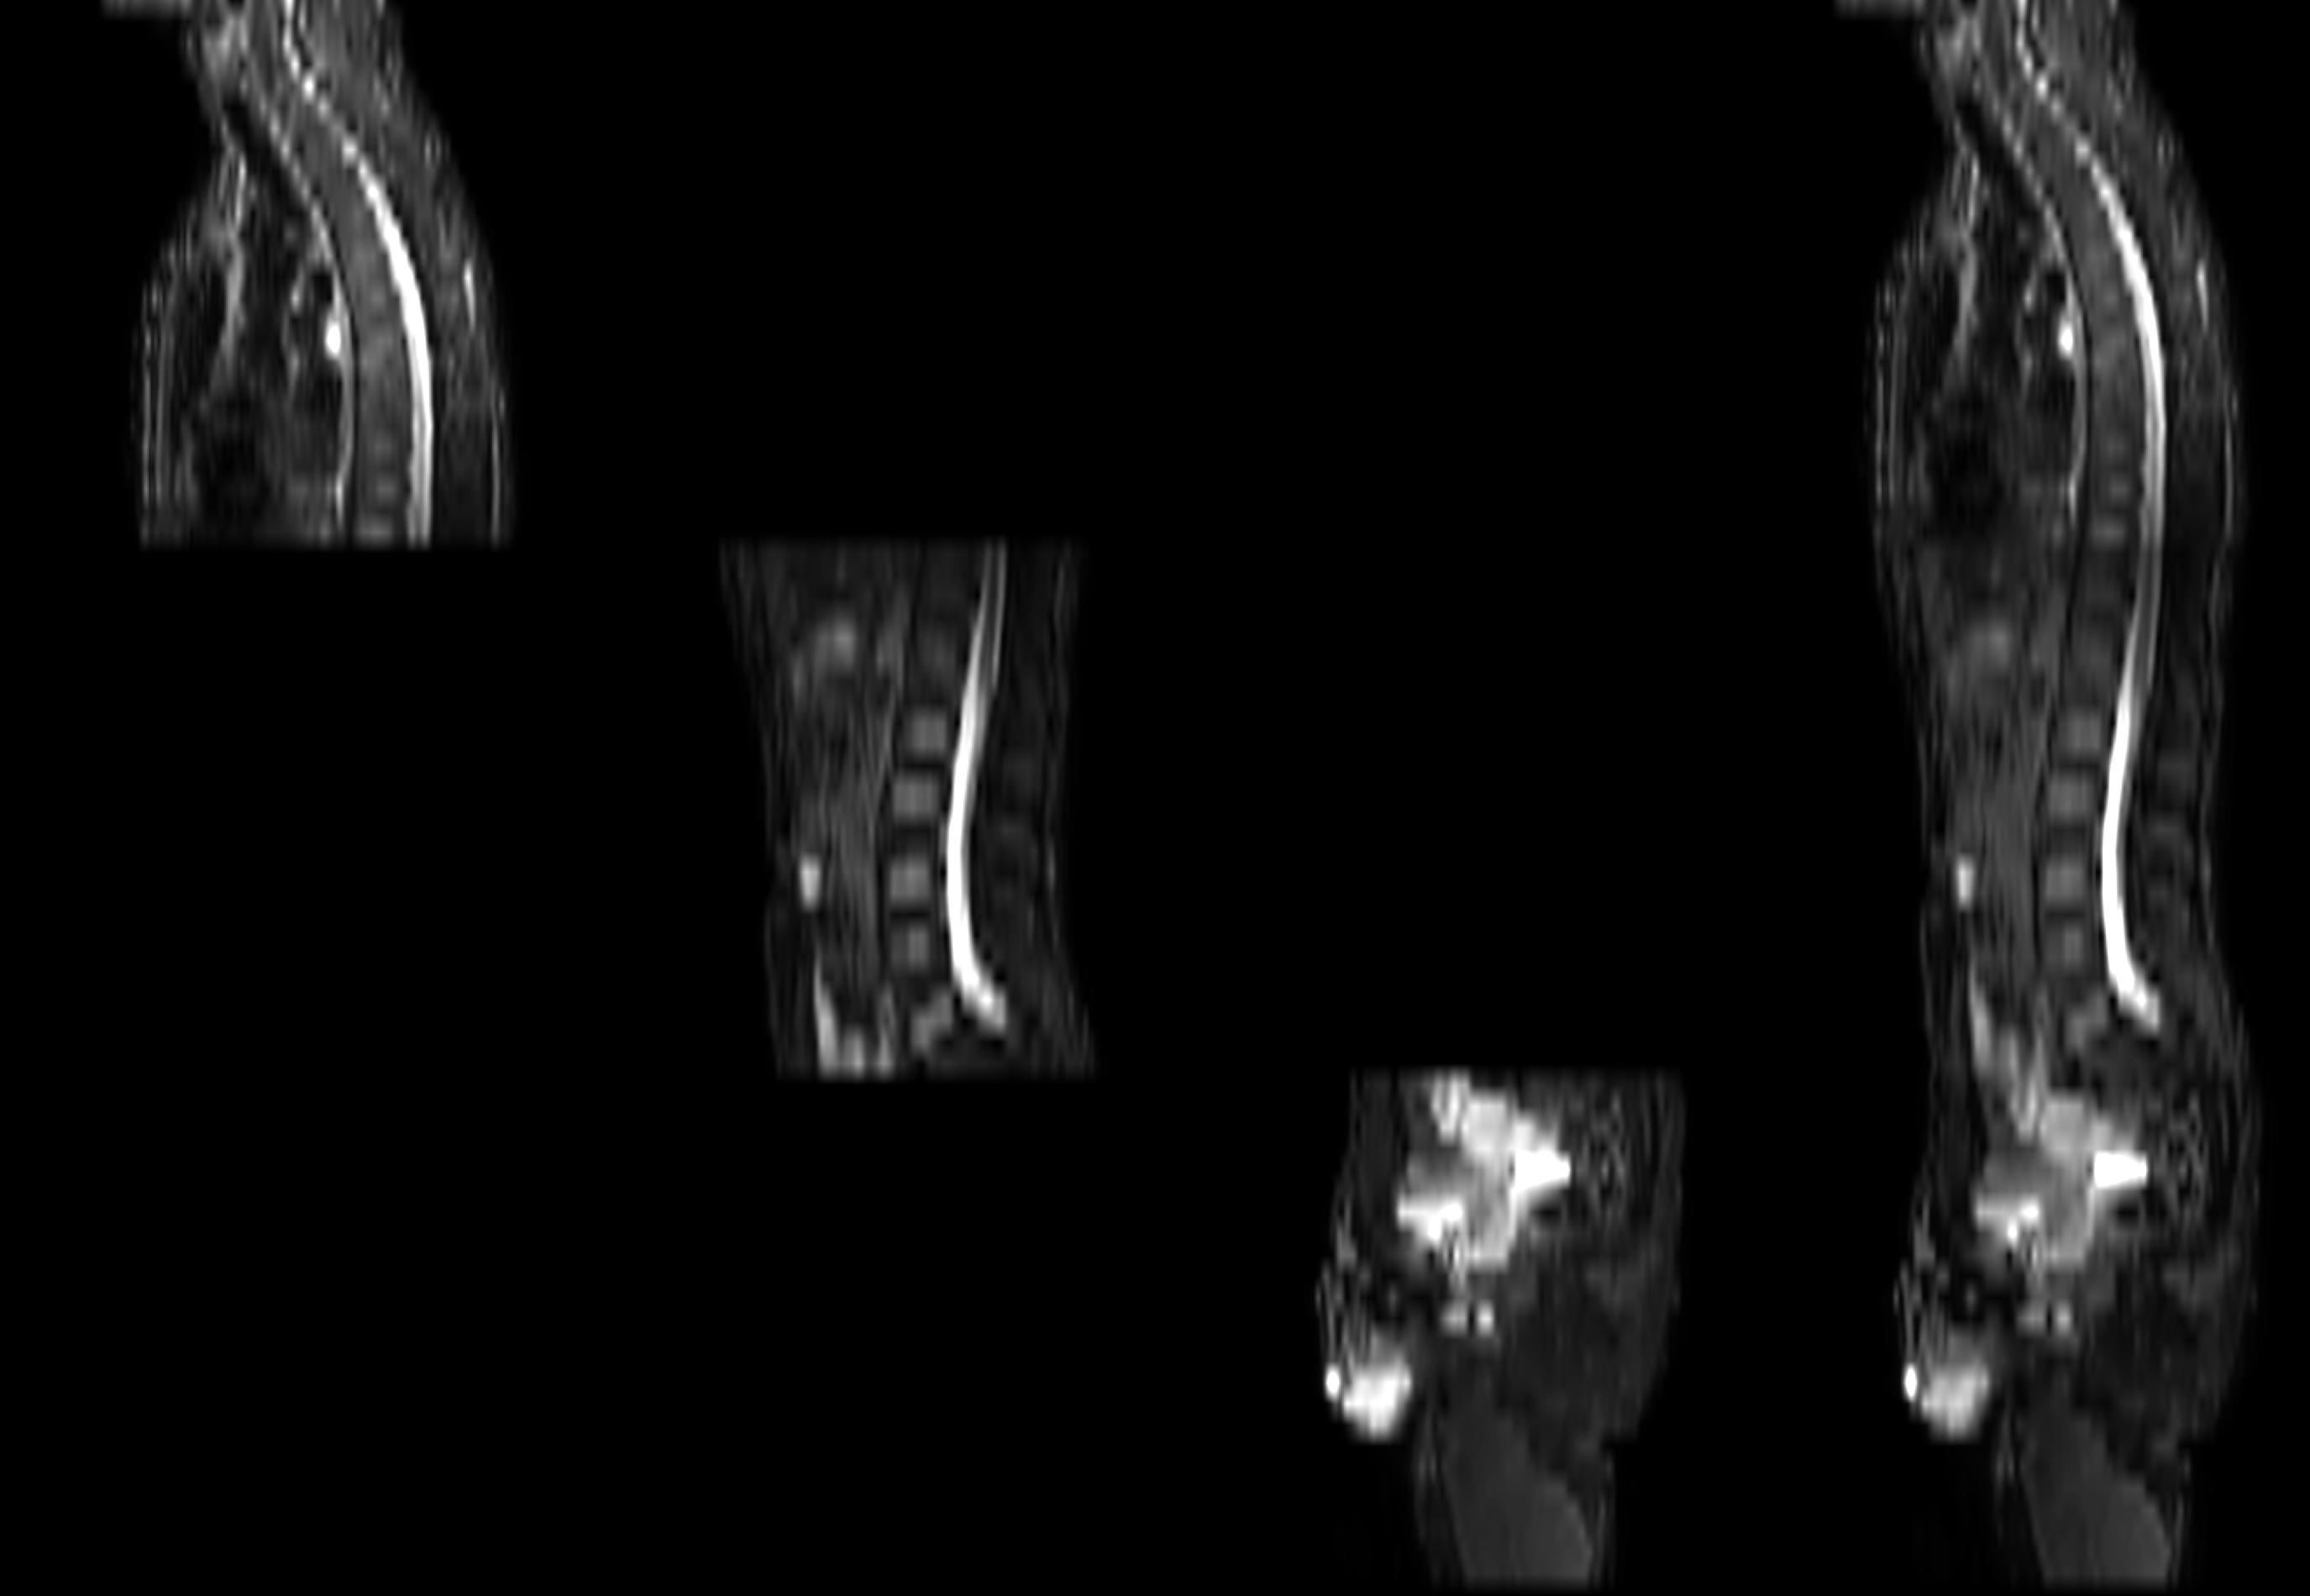

In [13]:
# show a stiched example
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, Visualization_Type, create_snapshot

### make snapshot
out_img = Path("out.jpg")
files = stitching_candidate[0]
files = sorted(files)
sequ: str = (files[0].get("sequ", "") + "-" if "sequ" in files[0].info else "") + "stiched"
t = files[0].get_changed_path("nii.gz", info={"sequ": sequ}, parent=derivative_folder)
a = [Snapshot_Frame(to_nii(i).resample_from_to(t, mode="constant"), sagittal=True) for i in files]
b = Snapshot_Frame(t, sagittal=True)

create_snapshot(out_img, [*a, b])
Image(filename=out_img)

# 3 Segmentation  

Note: by default we do not install Deep-learning stuff.

Install:

```pip install SPINEPS ruamel.yaml configargparse```

trouble shouting: nnunetv2==2.4.2


### TotalVibeSegmentator

https://arxiv.org/abs/2406.00125

https://github.com/robert-graf/TotalVibeSegmentator


In [16]:
from pathlib import Path

from TPTBox import BIDS_FILE
from TPTBox.segmentation import run_totalvibeseg

# run_totalvibeseg
# You can also use a string/Path if you want to set the path yourself.
### Just making in and output path
path_to_dicom_dataset = Path("tutorial_data_processing").absolute()
target_folder = path_to_dicom_dataset.parent
dataset = target_folder / "dataset-tutorial-data-processing"
in_file_dixon = BIDS_FILE(
    f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/dixon/sub-111168223_ses-20230128_sequ-501-stiched_acq-ax_part-water_dixon.nii.gz",
    dataset,
)
out_file_dixon = in_file_dixon.get_changed_path(
    "nii.gz", "msk", parent="derivative", info={"seg": "TotalVibeSegmentator", "mod": in_file_dixon.bids_format}
)
####
run_totalvibeseg(in_file_dixon, out_file_dixon, override=False)


100%|██████████| 36/36 [00:01<00:00, 33.42it/s]


Prediction done, transferring to CPU if needed
Stack predictions 3 torch.Size([73, 119, 298, 298])
logit_shape torch.Size([3, 73, 119, 298, 298])
convert_predicted_logits_to_segmentation_with_correct_shape torch.Size([73, 119, 298, 298])
[ ] resample_from_to: shape=(298, 298, 119),spacing=(1.41, 1.41, 3.0), origin={(207.26, 180.91, -103.05)}, ori=('L', 'P', 'S'), seg=True to shape=(511, 511, 89),spacing=(0.82, 0.82, 4.0), origin={(207.48, -236.65, -102.54)}, ori=('L', 'A', 'S'), seg=False
[*] Save /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/derivative/sub-111168223/ses-20230128/dixon/sub-111168223_ses-20230128_sequ-501-stiched_acq-ax_mod-dixon_part-water_seg-TotalVibeSegmentator_msk.nii.gz as uint8


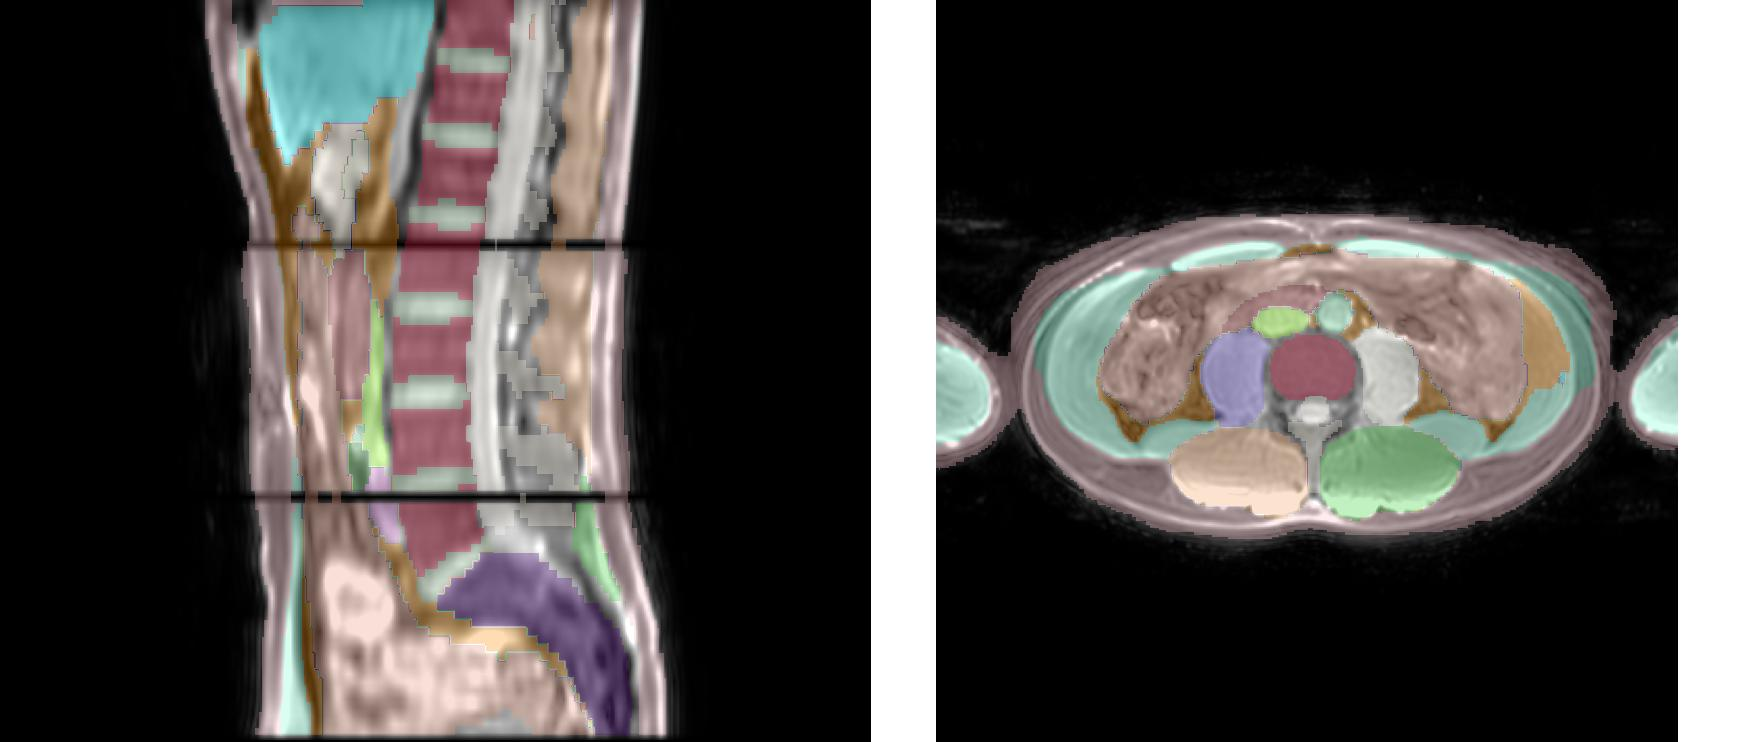

In [17]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")
a = Snapshot_Frame(
    in_file_dixon, segmentation=out_file_dixon, sagittal=True, axial=True, axial_heights=[0.5], ignore_seg_for_centering=True
)
create_snapshot(out_img, [a])
Image(filename=out_img)

In [18]:
in_file = BIDS_FILE(
    f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-201-stiched_acq-ax_part-inphase_T2w.nii.gz",
    dataset,
)
out_file = in_file.get_changed_path("nii.gz", "msk", parent="derivative", info={"seg": "TotalVibeSegmentator", "mod": in_file.bids_format})
####
run_totalvibeseg(in_file, out_file, override=False)

100%|██████████| 81/81 [00:02<00:00, 31.31it/s]


Prediction done, transferring to CPU if needed
Stack predictions 3 torch.Size([73, 304, 235, 318])
logit_shape torch.Size([3, 73, 304, 235, 318])
convert_predicted_logits_to_segmentation_with_correct_shape torch.Size([73, 304, 235, 318])
[ ] resample_from_to: shape=(318, 235, 304),spacing=(1.41, 1.41, 3.0), origin={(216.07, 164.47, -344.16)}, ori=('L', 'P', 'S'), seg=True to shape=(510, 376, 76),spacing=(0.88, 0.88, 12.0), origin={(216.07, -164.65, -344.16)}, ori=('L', 'A', 'S'), seg=False
[*] Save /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/derivative/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-201-stiched_acq-ax_mod-T2w_part-inphase_seg-TotalVibeSegmentator_msk.nii.gz as uint8


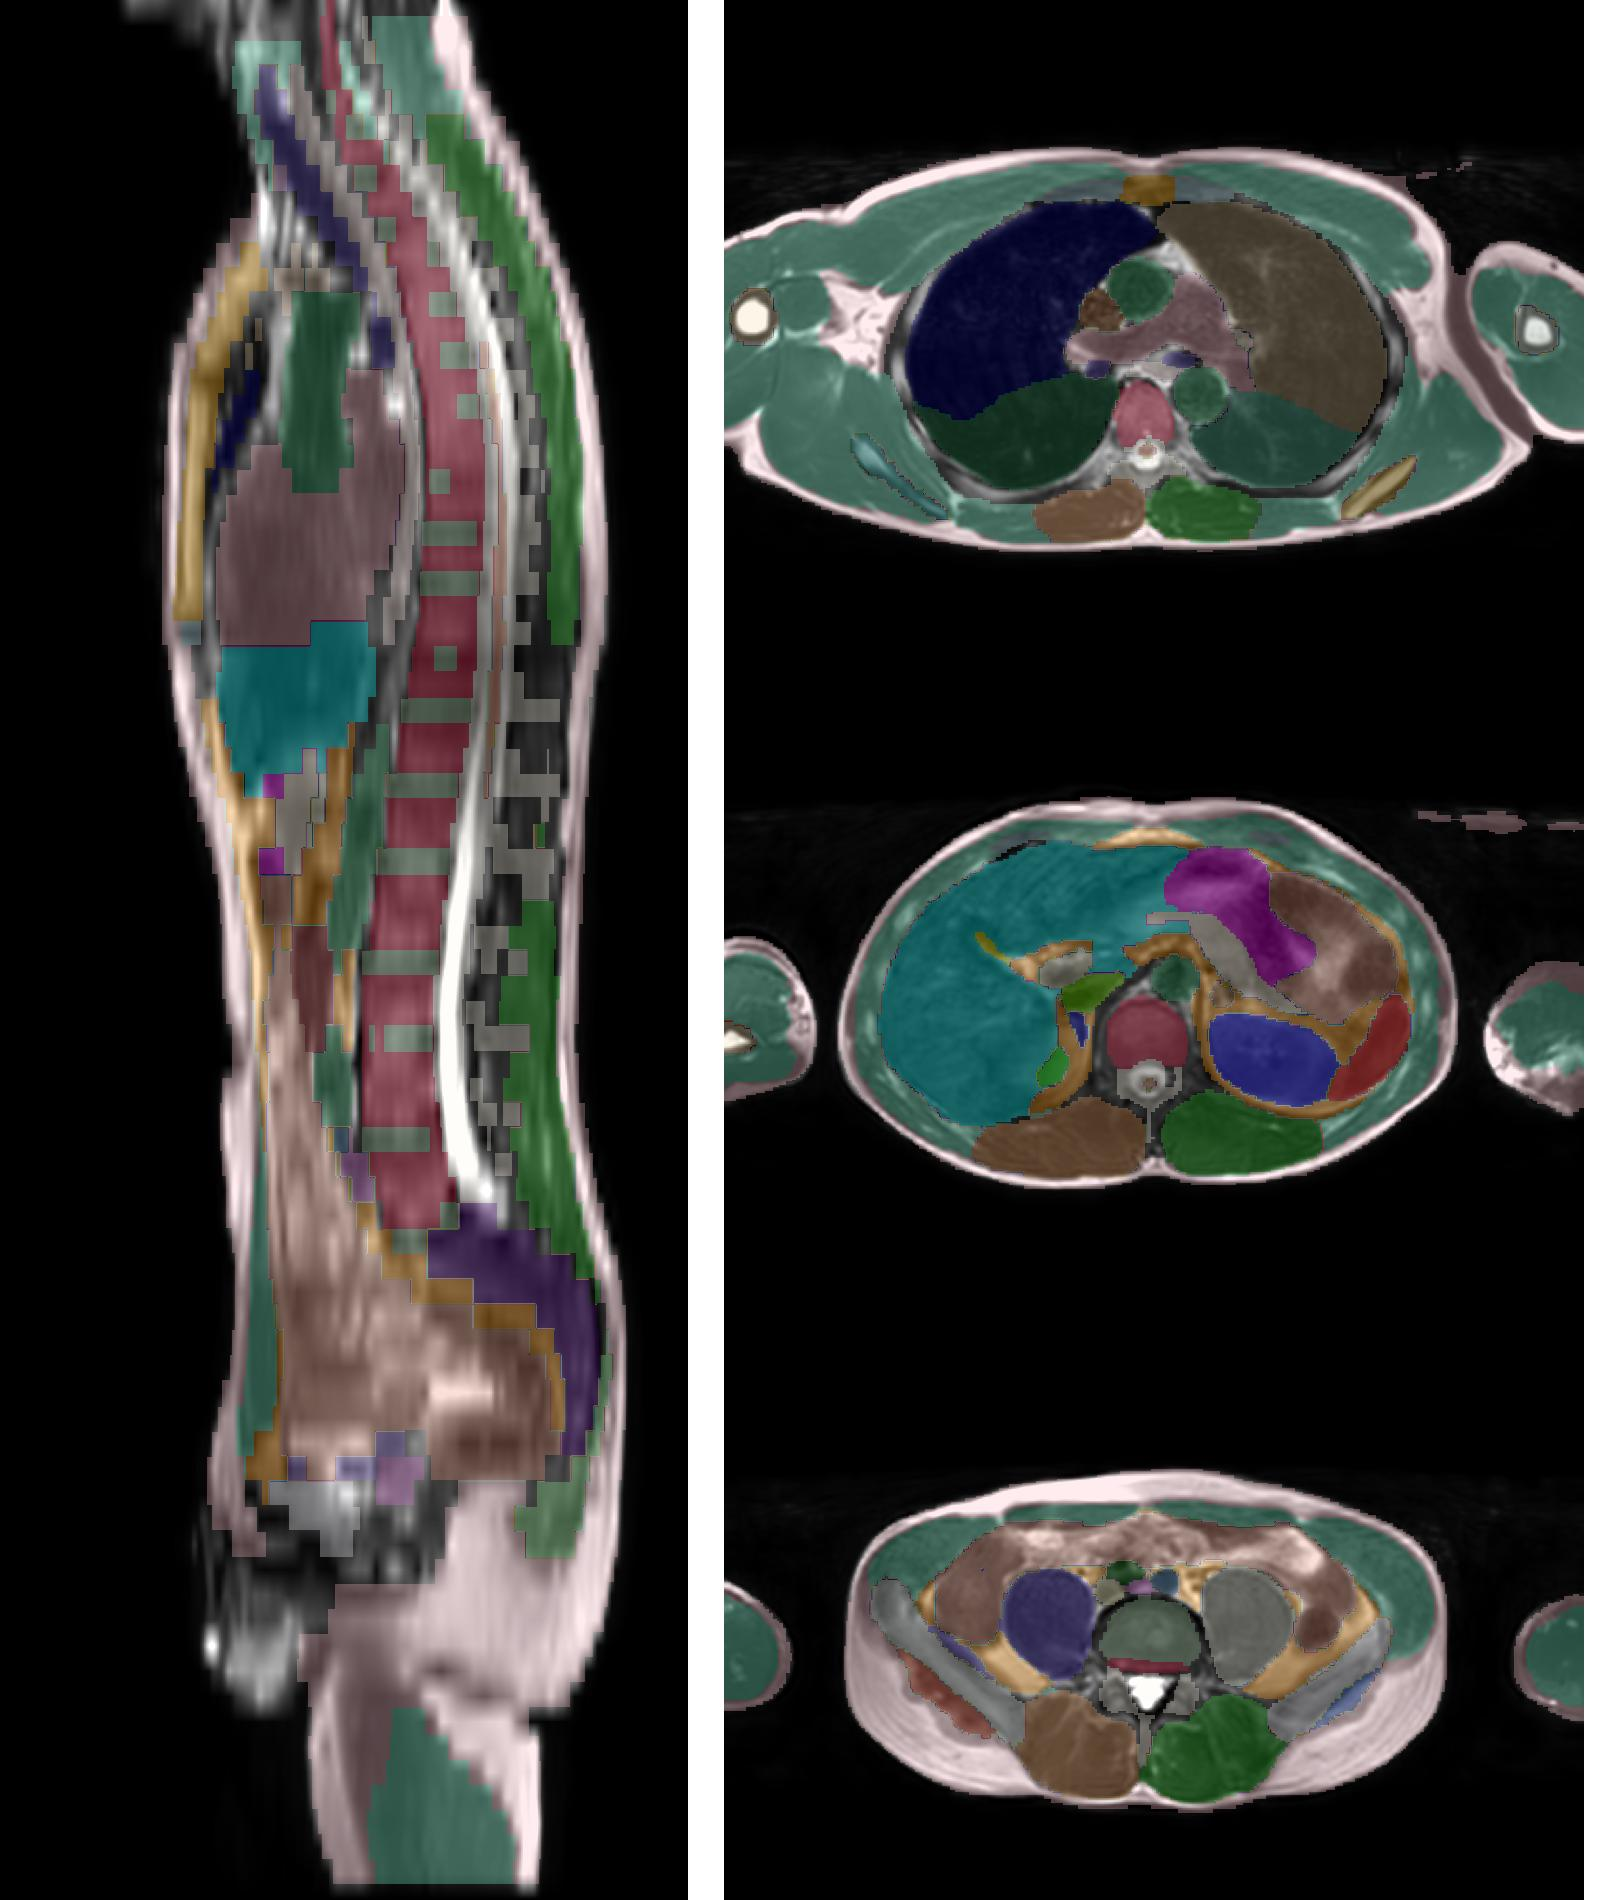

In [19]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")
a = Snapshot_Frame(in_file, segmentation=out_file, sagittal=True, axial=True, axial_heights=[0.2, 0.4, 0.6], ignore_seg_for_centering=True)
create_snapshot(out_img, [a])
Image(filename=out_img)

## spineps

Spineps can segment spine images in a instance and semantic mask. Running automatic over a dataset is very opinionated, what to segment. 
TODO: make a way to manully define output paths

https://github.com/Hendrik-code/spineps/tree/main

In [20]:
# If your model is BIDS compliant you can auto run spineps
# from TPTBox.segmentation import run_spineps_all
# run_spineps_all(dataset)

In [1]:
# Pick a fitting model:
from pathlib import Path

from spineps.get_models import modelid2folder_instance, modelid2folder_semantic

from TPTBox import BIDS_FILE

print("Available Semantic Models", modelid2folder_semantic())
print("Available Instance Models", modelid2folder_instance())

print(modelid2folder_semantic().keys())
print(modelid2folder_instance().keys())

### Just making in and output path
path_to_dicom_dataset = Path("tutorial_data_processing").absolute()
target_folder = path_to_dicom_dataset.parent
dataset = target_folder / "dataset-tutorial-data-processing"
in_file = BIDS_FILE(
    f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-401-stiched_acq-sag_part-inphase_T2w.nii.gz",
    dataset,
)
####

model_semantic = "t2w"
model_instance = "instance"
derivative_name = "derivative"

2025-03-24 16:20:11.951366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-24 16:20:12.583804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[Models] Check available models...
Available Semantic Models {'t2w': 'https://github.com/Hendrik-code/spineps/releases/download/v1.0.9/t2w.zip', 't1w': 'https://github.com/Hendrik-code/spineps/releases/download/v1.0.9/t1w.zip', 'vibe': 'https://github.com/Hendrik-code/spineps/releases/download/v1.0.9/vibe.zip', 't2w_semantic_v1.0.9': PosixPath('/DATA/NAS/tools/spineps/spineps/models/T2w_semantic_v1.0.9'), 'vibe_semantic_v1.0.9': PosixPath('/DATA/NAS/tools/spineps/spineps/models/Vibe_semantic_v1.0.9')}
Available Instance Models {'instance': 'https://github.com/Hendrik-code/spineps/releases/download/v1.2.0/instance.zip', 'instance_sagittal_v1.0.9': PosixPath('/DATA/NAS/tools/spineps/spineps/models/instance_sagittal_v1.0.9'), 'instance_sagittal_v1.2.0': PosixPath('/DATA/NAS/tools/spineps/spineps/models/instance_sagittal_v1.2.0')}
dict_keys(['t2w', 't1w', 'vibe', 't2w_semantic_v1.0.9', 'vibe_semantic_v1.0.9'])
dict_keys(['instance', 'instance_sagittal_v1.0.9', 'instance_sagittal_v1.2.0'])


In [ ]:
from TPTBox.segmentation.spineps import run_spineps_single

# With 'ignore_compatibility_issues = True' you can force to run the soft ware
out_paths = run_spineps_single(
    in_file,
    dataset=dataset,
    model_semantic=model_semantic,
    model_instance=model_instance,
    derivative_name=derivative_name,
    ignore_compatibility_issues=False,
    use_cpu=False,
    save_raw=True,
)
print(out_paths)

─────────────────────────────────────────── Thank you for using SPINEPS ───────────────────────────────────────────

Please support our development by citing

GitHub: https://github.com/Hendrik-code/spineps                                  
                                      ArXiv: https://arxiv.org/abs/2402.16368                                      
                                                     Thank you!

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[SPINEPS] Processing sub-111168223_ses-20230128_sequ-401-stiched_acq-sag_part-inphase_T2w.nii.gz
 - [SPINEPS] Input image (3.3, 0.271084, 0.271084) ('L', 'A', 'S') (14, 1032, 3092)
 - [SPINEPS] Prepare input image
 ---- [SPINEPS] N4 Bias field correction done in 24.74190354102757 sec
 ---- [SPINEPS] Shifted from range (0, 835) to range (0, 835)
 ---- [ ] Padd [(4, 4), (4, 4), (4, 4)]; mode='constant', {'constant_values': 0}
 - [SPINEPS] Predict Semantic Mask
 ---- [164_T2w_sag_2.0] Model loaded from /DATA/NAS/tools/spineps/spineps/models/T2w_semantic_v1.0.9


100%|██████████| 30/30 [00:02<00:00, 14.27it/s]


 ---- [SPINEPS] Post-process semantic mask...
 ---- [SPINEPS] Cleaned (label, n_components) {41: 1, 47: 1, 48: 2, 61: 8}
 ---- [SPINEPS] semantic_bounding_box_clean did not remove anything
 - [SPINEPS] Save /DATA/NAS/tools/TPTBox/tutorials/dataset-tutorial-data-processing/derivative/sub-111168223/ses-20230128/T2w/output_raw_T2w/sub-111168223_ses-20230128_sequ-401-stiched_acq-sag_mod-T2w_part-inphase_seg-spine-raw_msk.nii.gz as uint8
 - [SPINEPS] Predict instance mask
 ---- [SPINEPS] Image is already rotated to ('P', 'I', 'R')
 ---- [SPINEPS] Cleaned (label, n_components) {1: 7}


AttributeError: 'NII' object has no attribute 'get_segmentation_connected_components'

: 

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")
a = Snapshot_Frame(in_file, segmentation=out_paths["out_vert"], centroids=out_paths["out_ctd"], sagittal=True)
b = Snapshot_Frame(in_file, segmentation=out_paths["out_spine"], centroids=out_paths["out_ctd"], sagittal=True)
create_snapshot(out_img, [a, b])
Image(filename=out_img)

True

# 4 Point of interest

We have a JSON file format that can be rescaled like a nifty between local and global spaces.

The file is human-readable. Note: the POI file and numpy start counting with 0, while ITKSnap starts counting with 1. You have to subtract one in ITKSnap.

Loading a file you get a "POI" object. Every entry has two levels. They can become liberal. For Vertebra, it is `Vertebra-ID,` `Point number.`

https://doi.org/10.3389/fbioe.2022.862804 


In [ ]:
from TPTBox import NII, POI

nii_path = in_file
nii = NII.load(nii_path, False)
# Making a POI object in the same space as an image
poi_obj: POI = nii.make_empty_POI()
print(f"{nii =}")
print(f"{poi_obj=}")
# You can set, read poi Objects like you would access a 2D dictionary
poi_obj[19, 50] = (10, 20, 30)
print("Before rescaling", poi_obj[19, 50])
# We can use rescale, reorient, resample_from_to like in a nii
poi_obj = poi_obj.rescale((0.5, 0.5, 0.5))
print("After rescaling", poi_obj[19, 50])

Most common way to fill a POI object is by computing them from a Segmentation

Lets compute the center of mass of a instance segmentation. Like from SPINEPS

In [ ]:
from TPTBox import Location, calc_centroids

nii_instance_path = in_file  # MRI File
nii_instance_nii = NII.load(out_paths["out_vert"], seg=True)  # Instance mask
nii_instance_nii[nii_instance_nii > 100] = 0  # Only numbers below 100 are Vertebras

# You have to set one of the two keys. The other is coming from the numbers in the segmentation
print("First stage value (first_stage)", nii_instance_nii.unique())
print("Second stage value (second_stage)", Location.Vertebra_Full.value, "\n")
poi = calc_centroids(nii_instance_nii, second_stage=Location.Vertebra_Full.value)

print(poi, "num-points:", len(poi), "\n")
print("keys: ", poi.keys())
print(f"example point {poi[nii_instance_nii.unique()[0],Location.Vertebra_Full.value] =}")

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, Visualization_Type, create_snapshot

out_img = Path("out.jpg")
a = Snapshot_Frame(
    in_file,
    segmentation=nii_instance_nii,
    centroids=poi,
    sagittal=True,
    only_mask_area=True,
    visualization_type=Visualization_Type.Maximum_Intensity,
)
create_snapshot(out_img, [a])
Image(filename=out_img)

For our Vertebra segmentation, we have a rule-based pipeline to generate points.

You need the instance and subregion mask from spineps.

In [ ]:
import numpy as np

from TPTBox import Location, Vertebra_Instance, calc_poi_from_subreg_vert

nii_instance_path = out_paths["out_vert"]
nii_semantic_path = out_paths["out_spine"]

# We can compute the direction of the Vertebra
subreg_ids = [
    Location.Vertebra_Corpus,
    Location.Vertebra_Direction_Inferior,
    Location.Vertebra_Direction_Right,
    Location.Vertebra_Direction_Posterior,
]
poi_fixed = calc_poi_from_subreg_vert(nii_instance_path, nii_semantic_path, subreg_id=subreg_ids)
# Note: we may need to compute additional points that than are also in the poi file.
poi_fixed.extract_subregion_(*subreg_ids)


### PRINTING ####
print(poi_fixed, "\n")

print("L1 Corpus", poi_fixed[Vertebra_Instance.L1, Location.Vertebra_Corpus], "\n")

v = np.array(poi_fixed[Vertebra_Instance.L1, Location.Vertebra_Direction_Inferior]) - np.array(
    poi_fixed[Vertebra_Instance.L1, Location.Vertebra_Corpus]
)
v /= np.sqrt((v**2).sum())
print("normal down drection", v, poi_fixed.orientation, "\n")
poi_fixed_slp = poi_fixed.reorient(("S", "L", "P"))
v = np.array(poi_fixed_slp[Vertebra_Instance.L1, Location.Vertebra_Direction_Inferior]) - np.array(
    poi_fixed_slp[Vertebra_Instance.L1, Location.Vertebra_Corpus]
)
v /= np.sqrt((v**2).sum())
print("normal down drection after reorientation", v, poi_fixed_slp.orientation, "\n")
##Not this is normalized to image space. If you want the direction in global space, resample to (1,1,1) mm


In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, Visualization_Type, create_snapshot

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(in_file, segmentation=out_paths["out_vert"], centroids=poi_fixed, coronal=True, sagittal=True)
b = Snapshot_Frame(in_file, segmentation=out_paths["out_spine"], centroids=poi_fixed, sagittal=True)
create_snapshot(out_img, [a, b])
Image(filename=out_img)

We can compute the points described in 

"Validation of a Patient-Specific Musculoskeletal Model for Lumbar Load Estimation Generated by an Automated Pipeline From Whole Body CT"

https://doi.org/10.3389/fbioe.2022.862804 

![Special POIs](https://www.frontiersin.org/files/Articles/862804/fbioe-10-862804-HTML/image_m/fbioe-10-862804-g002.jpg)

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

new_pois = [
    Location.Vertebra_Corpus,
    Location.Additional_Vertebral_Body_Middle_Inferior_Median,
    Location.Additional_Vertebral_Body_Middle_Superior_Median,
    Location.Additional_Vertebral_Body_Posterior_Central_Median,
    Location.Additional_Vertebral_Body_Anterior_Central_Median,
    Location.Ligament_Attachment_Point_Anterior_Longitudinal_Superior_Median,
    Location.Ligament_Attachment_Point_Posterior_Longitudinal_Superior_Median,
    Location.Ligament_Attachment_Point_Anterior_Longitudinal_Inferior_Median,
    Location.Ligament_Attachment_Point_Posterior_Longitudinal_Inferior_Median,
]

poi_fixed = calc_poi_from_subreg_vert(
    nii_instance_path, nii_semantic_path, subreg_id=[Location.Vertebra_Direction_Inferior, *new_pois]
).extract_subregion(*new_pois)

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(in_file, segmentation=out_paths["out_vert"], centroids=poi_fixed, sagittal=True)
b = Snapshot_Frame(in_file, segmentation=out_paths["out_spine"], centroids=poi_fixed, sagittal=True)
create_snapshot(out_img, [a, b])
Image(filename=out_img)


# 5 Point Registration

We can use two POI objects for point registration. Only points that exist in both POIs are considered. 


We recommend spine registration at least two points per Vertebra to prevent rotation around the spine. See https://doi.org/10.1186/s41747-023-00385-2

In [ ]:
from TPTBox import to_nii

### MAKE an artificial example ###
dataset = target_folder / "dataset-tutorial-data-processing"
nii_instance = to_nii(out_paths["out_vert"], True)
nii_semantic = to_nii(out_paths["out_spine"], True)
fixed_image = to_nii(
    f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-401-stiched_acq-sag_part-inphase_T2w.nii.gz"
)

crop1 = (slice(None), slice(None), slice(0, 2000))
crop2 = (slice(None), slice(None), slice(1500, None))

nii_instance1 = nii_instance.copy().apply_crop(crop1)
nii_semantic1 = nii_semantic.copy().apply_crop(crop1)
fixed_image1 = fixed_image.copy().apply_crop(crop1)

nii_instance2 = nii_instance.copy().apply_crop(crop2)
nii_semantic2 = nii_semantic.copy().apply_crop(crop2)
image2 = fixed_image.copy().apply_crop(crop2)

nii_instance2.origin = (nii_instance2.origin[0] + 1, nii_instance2.origin[1] - 3, nii_instance2.origin[2] - 190)
nii_semantic2.origin = nii_instance2.origin
image2.origin = nii_instance2.origin


In [ ]:
from pathlib import Path

from TPTBox import NII, Location, Vertebra_Instance, calc_poi_from_subreg_vert, to_nii
from TPTBox.registration import Point_Registration, ridged_points_from_poi

# Example registration two sagittal images, like for compensating movement between scans.
poi_fixed = calc_poi_from_subreg_vert(nii_instance1, nii_semantic1, subreg_id=[Location.Vertebra_Corpus, Location.Spinosus_Process]).round(
    2
)
poi_moving = calc_poi_from_subreg_vert(nii_instance2, nii_semantic2, subreg_id=[Location.Vertebra_Corpus, Location.Spinosus_Process]).round(
    2
)

registration_object: Point_Registration = ridged_points_from_poi(poi_fixed, poi_moving, c_val=0)

# Move image
moved_nii = registration_object.transform_nii(image2)
print(moved_nii, "\n", image2, "\n")
# Move poi
moved_poi = registration_object.transform_poi(poi_moving).round(1)
print(moved_poi, "\n", poi_moving, "\n")


In [ ]:
from TPTBox import NII, Location, Vertebra_Instance, calc_poi_from_subreg_vert
from TPTBox.registration import Point_Registration, ridged_points_from_poi
from TPTBox.segmentation.TotalVibeSeg import extract_vertebra_bodies_from_totalVibe

# Example registration two sagittal images, like for compensating movement between scans.
poi_fixed = calc_poi_from_subreg_vert(nii_instance1, nii_semantic1, subreg_id=[Location.Vertebra_Corpus, Location.Spinosus_Process]).round(
    2
)
poi_moving = calc_poi_from_subreg_vert(nii_instance2, nii_semantic2, subreg_id=[Location.Vertebra_Corpus, Location.Spinosus_Process]).round(
    2
)
registration_object: Point_Registration = ridged_points_from_poi(poi_fixed, poi_moving, c_val=0)
# Move image
moved_nii = registration_object.transform_nii(image2, output_space=fixed_image)
print(moved_nii, "\n", image2, "\n")
# Move poi
moved_poi = registration_object.transform_poi(poi_moving).round(1)
print(moved_poi, "\n", poi_moving, "\n")


In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")
poi_all = moved_poi.resample_from_to(moved_nii).join_left(poi_fixed.resample_from_to(moved_nii))
x = Snapshot_Frame(image2.resample_from_to(moved_nii, mode="constant"), centroids=poi_moving.resample_from_to(moved_nii), sagittal=True)
a = Snapshot_Frame(
    fixed_image1.resample_from_to(moved_nii, mode="constant"), centroids=poi_fixed.resample_from_to(moved_nii), sagittal=True
)
b = Snapshot_Frame(moved_nii, centroids=moved_poi.resample_from_to(moved_nii), sagittal=True)
c = Snapshot_Frame(fixed_image, centroids=poi_all, sagittal=True)
create_snapshot(out_img, [x, a, b, c])
Image(filename=out_img)

In [ ]:
from TPTBox import NII, Location, Vertebra_Instance, calc_poi_from_subreg_vert
from TPTBox.registration import Point_Registration, ridged_points_from_poi
from TPTBox.segmentation.TotalVibeSeg import extract_vertebra_bodies_from_totalVibe

# Example registration axial and sagittal with points.
# T2w axial points are computed from the total vibe segment.
dataset = target_folder / "dataset-tutorial-data-processing"

nii_instance_path2 = out_paths["out_vert"]
nii_semantic_path2 = out_paths["out_spine"]
# We recommend if you registrade spineps points too use at least two points.
poi_fixed = calc_poi_from_subreg_vert(nii_instance_path, nii_semantic_path, subreg_id=[Location.Vertebra_Corpus]).round(1)
fixed_image = BIDS_FILE(
    f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-401-stiched_acq-sag_part-inphase_T2w.nii.gz",
    dataset,
)

moving_file = BIDS_FILE(
    f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/dixon/sub-111168223_ses-20230128_sequ-501-stiched_acq-ax_part-water_dixon.nii.gz",
    dataset,
)
out_file = moving_file.get_changed_path(
    "nii.gz", "msk", parent="derivative", info={"seg": "TotalVibeSegmentator", "mod": moving_file.bids_format}
)
moving_image = to_nii(moving_file)
out_file = to_nii(out_file, True)

#### Let's move the image, so we see better that the registration is working.
moving_image.origin = (moving_image.origin[0], moving_image.origin[1], moving_image.origin[2] + 175)
out_file.origin = moving_image.origin
####

# Ensure that we count the same as in the T2w sagittal
num_thoracic_verts = 12
if Vertebra_Instance.T13.value in poi_fixed.keys_region():
    num_thoracic_verts = 13
if Vertebra_Instance.T12.value not in poi_fixed.keys_region():
    num_thoracic_verts = 11
num_lumbar_verts = 5
if Vertebra_Instance.L6.value in poi_fixed.keys_region():
    num_lumbar_verts = 6
if Vertebra_Instance.L5.value not in poi_fixed.keys_region():
    num_lumbar_verts = 4
# Note: this function currently assumes that we see the sacrum in the image.
nii, poi_moving = extract_vertebra_bodies_from_totalVibe(out_file, num_lumbar_verts=num_lumbar_verts, num_thoracic_verts=num_thoracic_verts)

registration_object: Point_Registration = ridged_points_from_poi(poi_fixed, poi_moving, c_val=0)

# Move image
moved_nii = registration_object.transform_nii(moving_image)
print(moved_nii, "\n", moving_image, "\n")
# Move poi
moved_poi = registration_object.transform_poi(poi_moving).round(1)
print(moved_poi, "\n", poi_moving, "\n")


In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(moving_image, segmentation=nii, centroids=poi_moving, sagittal=True)
create_snapshot(out_img, [a])
Image(filename=out_img)

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(moving_image.resample_from_to(moved_nii, mode="constant"), centroids=poi_fixed, sagittal=True)
b = Snapshot_Frame(moved_nii, centroids=poi_fixed, sagittal=True)
c = Snapshot_Frame(fixed_image, centroids=poi_fixed, sagittal=True)
create_snapshot(out_img, [a, b, c])
Image(filename=out_img)

# 6 Deformable registration for different breath holds compensation

With our point pre-registration, we can use deformable registration to remove breathing.

(Our example did not suffer from breathing movement, so we used similar images from ammos22)

This example needs Deepali installed.

In [ ]:
from pathlib import Path

from TPTBox import to_nii
from TPTBox.registration.deformable import Deformable_Registration

moving_nii = to_nii(Path("tutorial_data_processing/PixelPandemonium/mr_0.nii.gz").absolute(), False)
fixed_nii = to_nii(Path("tutorial_data_processing/PixelPandemonium/mr_1.nii.gz").absolute(), False)


reg = Deformable_Registration(fixed_nii,moving_nii, normalize_strategy="MRI", device="cuda",mask_foreground=False,verbose=99,lr=0.01)

moved_nii = reg.transform_nii(moving_nii)


In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")


a = Snapshot_Frame(moving_nii.resample_from_to(moved_nii, mode="constant"), sagittal=False, axial=True, axial_heights=[0.5], mode="MRI")
b = Snapshot_Frame(moved_nii, sagittal=False, axial=True, axial_heights=[0.5], mode="MRI")
c = Snapshot_Frame(fixed_nii.resample_from_to(moved_nii, mode="constant"), sagittal=False, axial=True, axial_heights=[0.5], mode="MRI")
create_snapshot(out_img, [a, b, c])
Image(filename=out_img)

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(moving_nii.resample_from_to(moved_nii, mode="constant"), sagittal=True, mode="MRI")
b = Snapshot_Frame(moved_nii, sagittal=True, mode="MRI")
c = Snapshot_Frame(fixed_nii.resample_from_to(moved_nii, mode="constant"), sagittal=True, mode="MRI")
create_snapshot(out_img, [a, b, c])
Image(filename=out_img)